In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from nltk.stem import PorterStemmer
from string import punctuation
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
nltk.download('stopwords')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import warnings

warnings.filterwarnings('ignore') # We can suppress the warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df1 = pd.read_csv('covidvaccine.csv')
df2 = pd.read_csv('vaccination_all_tweets.csv')

In [3]:
tweets_df=pd.concat([df1,df2], ignore_index=True)

In [4]:
tweets_df.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,id,retweets,favorites
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64.0,11.0,110.0,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,False,NaN,NaN,NaN
1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1.0,17.0,0.0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,False,NaN,NaN,NaN
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143.0,566.0,8.0,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,False,NaN,NaN,NaN
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25.0,620.0,False,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco...,NaN,Twitter for Android,False,NaN,NaN,NaN
4,Ann-Maree O’Connor,"Adelaide, South Australia",Retired university administrator. Melburnian b...,24-01-2013 14:53,83.0,497.0,10737.0,False,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what...,NaN,Twitter Web App,False,NaN,NaN,NaN


In [5]:
print(tweets_df.columns)

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'id', 'retweets',
       'favorites'],
      dtype='object')


In [6]:
tweets_df=tweets_df.drop(['id','retweets','favorites','user_name','is_retweet','user_location','user_followers','user_friends','user_favourites','user_verified','hashtags','source','user_created','user_description'],axis =1)
tweets_df.head(5)

,date,text
0,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...
1,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...
2,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...
3,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco...
4,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what...


In [7]:
tweets_df.tail(5)

,date,text
627847,2021-11-15 09:00:15,45+ #URBAN #Bengaluru #CovidVaccine Availabili...
627848,2021-11-15 08:30:26,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...
627849,2021-11-15 08:30:15,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...
627850,2021-11-15 08:03:03,They promote their Vaccines leaving out the st...
627851,2021-11-15 08:00:15,45+ #URBAN #Bengaluru #CovidVaccine Availabili...


In [8]:
tweets_df.isnull().sum()

date    50
text    48
dtype: int64

In [9]:
tweets_df = tweets_df.dropna(axis=0)

In [10]:
tweets_df.shape

(627802, 2)

In [11]:
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

In [12]:
valid_tweets_df = tweets_df.dropna(subset=['date'])

In [13]:
valid_tweets_df['day'] = valid_tweets_df['date'].dt.day
valid_tweets_df['weekofyear'] = valid_tweets_df['date'].dt.isocalendar().week
valid_tweets_df['month'] = valid_tweets_df['date'].dt.month

In [14]:
tweets_df['day'] = tweets_df['date'].dt.day
tweets_df['week'] = tweets_df['date'].dt.week
tweets_df['month'] = tweets_df['date'].dt.month

In [15]:
tweets_df.isnull().sum()

date     7
text     0
day      7
week     7
month    7
dtype: int64

In [16]:
tweets_df = tweets_df.dropna(axis=0)

In [17]:
tweets_df.shape

(627795, 5)

In [18]:
tweets_df.head()

,date,text,day,week,month
0,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,18.0,34.0,8.0
1,2020-08-18 12:55:00,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,18.0,34.0,8.0
2,2020-08-18 12:46:00,Deaths due to COVID-19 in Affected Countries\n...,18.0,34.0,8.0
3,2020-08-18 12:45:00,@Team_Subhashree @subhashreesotwe @iamrajchoco...,18.0,34.0,8.0
4,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,18.0,34.0,8.0


In [19]:
tweets_df.dtypes

date     datetime64[ns]
text             object
day             float64
week            float64
month           float64
dtype: object

In [20]:
tweets_df['day'] = tweets_df['day'].astype(int)
tweets_df['week'] = tweets_df['week'].astype(int)
tweets_df['month'] = tweets_df['month'].astype(int)
# Print the updated DataFrame
print(tweets_df)


                      date                                               text  \
0      2020-08-18 12:55:00  Australia to Manufacture Covid-19 Vaccine and ...   
1      2020-08-18 12:55:00  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2      2020-08-18 12:46:00  Deaths due to COVID-19 in Affected Countries\n...   
3      2020-08-18 12:45:00  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4      2020-08-18 12:45:00  @michellegrattan @ConversationEDU This is what...   
...                    ...                                                ...   
627847 2021-11-15 09:00:15  45+ #URBAN #Bengaluru #CovidVaccine Availabili...   
627848 2021-11-15 08:30:26  18-44 #BBMP #Bengaluru #CovidVaccine Availabil...   
627849 2021-11-15 08:30:15  18-44 #URBAN #Bengaluru #CovidVaccine Availabi...   
627850 2021-11-15 08:03:03  They promote their Vaccines leaving out the st...   
627851 2021-11-15 08:00:15  45+ #URBAN #Bengaluru #CovidVaccine Availabili...   

        day  week  month  


In [21]:
tweets_df.isnull().sum()

date     0
text     0
day      0
week     0
month    0
dtype: int64

In [22]:
tweets_df.dtypes

date     datetime64[ns]
text             object
day               int32
week              int32
month             int32
dtype: object

In [23]:
tweets_df.describe()

,day,week,month
count,627795.000000,627795.000000,627795.000000
mean,16.570403,22.686097,5.639924
std,8.420312,15.044057,3.433514
min,1.000000,1.000000,1.000000
25%,10.000000,9.000000,2.000000
50%,17.000000,22.000000,6.000000
75%,24.000000,33.000000,8.000000
max,31.000000,53.000000,12.000000


In [24]:
tweets_df.head(5)

,date,text,day,week,month
0,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,18,34,8
1,2020-08-18 12:55:00,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,18,34,8
2,2020-08-18 12:46:00,Deaths due to COVID-19 in Affected Countries\n...,18,34,8
3,2020-08-18 12:45:00,@Team_Subhashree @subhashreesotwe @iamrajchoco...,18,34,8
4,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,18,34,8


In [25]:
tweets_df.tail()

,date,text,day,week,month
627847,2021-11-15 09:00:15,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,15,46,11
627848,2021-11-15 08:30:26,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,15,46,11
627849,2021-11-15 08:30:15,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,15,46,11
627850,2021-11-15 08:03:03,They promote their Vaccines leaving out the st...,15,46,11
627851,2021-11-15 08:00:15,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,15,46,11


In [26]:
# Find the range of the 'week' column
week_min = tweets_df['week'].min()
week_max = tweets_df['week'].max()
print(f"Week range: {week_min} - {week_max}")

# Find the range of the 'day' column
day_min = tweets_df['day'].min()
day_max = tweets_df['day'].max()
print(f"Day range: {day_min} - {day_max}")

# Find the range of the 'month' column
month_min = tweets_df['month'].min()
month_max = tweets_df['month'].max()
print(f"Month range: {month_min} - {month_max}")


Week range: 1 - 53
Day range: 1 - 31
Month range: 1 - 12


In [27]:
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [28]:
#Covid_refs=['Covid Vaccine','CovidVaccine','COVID19','Coronavirus', 'Corona','Covid-19','']

In [29]:
Pfizer_refs=['PfizerBioNTech', 'Pfizer','Pfizer-BioNtech','BioNtech', 'pfizer vaccine','freerange']
#AstraZeneca_refs=['Astra vaccine','AstraZeneca Vaccine', 'AstraZeneca', 'Oxford-AstraZeneca','astrazeneca']

In [30]:
def identify_subject(tweet, refs):
    flag = 0
    for ref in refs:
        if tweet.find(ref) !=-1:
            flag =1
    return flag
tweets_df['Pfizer']=tweets_df['text'].apply(lambda x: identify_subject(x, Pfizer_refs))

In [31]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    txt = re.sub(r'#', '',txt)
    txt = re.sub(r'RT: ', '',txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    return txt

In [32]:
tweets_df['text'] = tweets_df['text'].apply(cleanUpTweet)

In [33]:
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

In [34]:
def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

In [35]:
tweets_df['Polarity']= tweets_df['text'].apply(getTextPolarity)

In [36]:
tweets_df.head(20)
Pfizer = tweets_df[tweets_df['Pfizer'] ==1][['date','Polarity']]
Pfizer = Pfizer.sort_values(by = 'date', ascending = True)
Pfizer['OR Polarity'] = Pfizer.Polarity.rolling(10, min_periods=3).mean()

tweets_df.head(20)
Covid = tweets_df[tweets_df['Covid'] ==1][['date','Polarity']]
Covid = Covid.sort_values(by = 'date', ascending = True)
Covid['OR Polarity'] = Covid.Polarity.rolling(10, min_periods=3).mean()

In [37]:
Pfizer.head()

,date,Polarity,OR Polarity
5758,2020-03-09 10:20:00,0.0,NaN
5689,2020-03-09 17:22:00,0.1,NaN
5679,2020-03-09 18:28:00,0.0,0.033333
5662,2020-03-09 20:23:00,0.0,0.025000
5638,2020-03-09 21:28:00,0.3,0.080000


In [38]:
tweets_df.isnull().sum()

date        0
text        0
day         0
week        0
month       0
Pfizer      0
Polarity    0
dtype: int64

In [39]:
tweets_df.shape

(627795, 7)

In [40]:
def getTextAnalysis(a):
    if a<0:
        return "Negative"
    elif a==0:
        return "Neutral"
    else:
        return "Positive"

In [41]:
score = 1
sentiment = getTextAnalysis(score)
print(sentiment)


Positive


In [42]:
tweets_df["Score"]= tweets_df['Polarity'].apply(getTextAnalysis)

In [43]:
tweets_df.head(2)

,date,text,day,week,month,Pfizer,Polarity,Score
0,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,18,34,8,0,0.40,Positive
1,2020-08-18 12:55:00,CoronavirusVaccine CoronaVaccine CovidVaccine ...,18,34,8,0,0.91,Positive


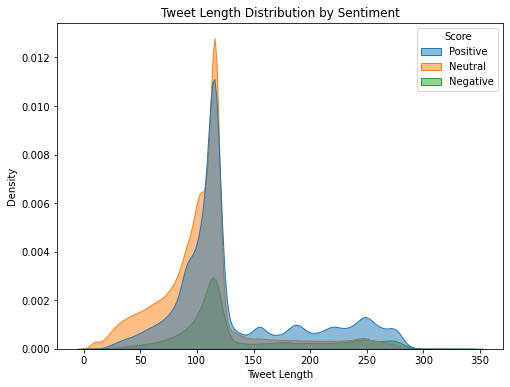

In [44]:
import matplotlib.pyplot as plt

# Creating a new column 'length' with the text length of each tweet
tweets_df['length'] = tweets_df['text'].apply(lambda x: len(str(x)))

# Plot the density graph
plt.figure(figsize=(8, 6))
sns.kdeplot(data=tweets_df, x='length', fill=True, hue='Score', alpha=0.5)

# Set the plot title and axis labels
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Density')

# Display the plot
plt.show()


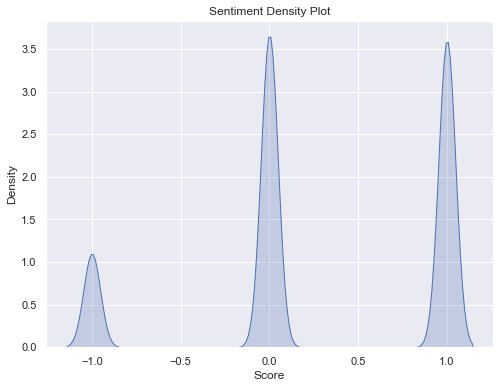

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping dictionary for encoding sentiment categories
sentiment_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}

# Encode the Score column using the mapping dictionary
tweets_df['Score_Encoded'] = tweets_df['Score'].map(sentiment_mapping)

# Set the style and figure size
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (8, 6)})

# Create the density plot
sns.kdeplot(data=tweets_df, x='Score_Encoded', fill=True, palette=['red', 'blue', 'green'])

# Set the plot title and axis labels
plt.title('Sentiment Density Plot')
plt.xlabel('Score')
plt.ylabel('Density')

# Display the plot
plt.show()


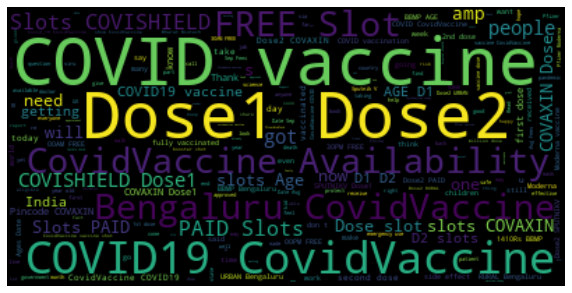

In [46]:
from wordcloud import WordCloud
# Create a WordCloud object
# Combine all the clean sentiments into a single string
text = ' '.join(tweets_df['text'])

wordcloud = WordCloud(min_font_size=1, max_words=200, random_state=1234).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [47]:
tweets_df.head(10)

,date,text,day,week,month,Pfizer,Polarity,Score,length,Score_Encoded
0,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,18,34,8,0,0.400000,Positive,126,1
1,2020-08-18 12:55:00,CoronavirusVaccine CoronaVaccine CovidVaccine ...,18,34,8,0,0.910000,Positive,75,1
2,2020-08-18 12:46:00,Deaths due to COVID-19 in Affected Countries\n...,18,34,8,0,0.187500,Positive,60,1
3,2020-08-18 12:45:00,Stay safe di &amp; da ❤️❤️…,18,34,8,0,0.500000,Positive,33,1
4,2020-08-18 12:45:00,This is what passes for leadership in our co...,18,34,8,0,0.000000,Neutral,85,0
5,2020-08-18 12:44:00,The Multi-system Inflammatory Syndrome-Childre...,18,34,8,0,0.000000,Neutral,115,0
6,2020-08-18 12:34:00,…,18,34,8,0,0.000000,Neutral,9,0
7,2020-08-18 12:30:00,"Well, let’s qualify that: would anyone of any...",18,34,8,0,-0.100000,Negative,131,-1
8,2020-08-18 12:15:00,"Most countries, without the ability to make Va...",18,34,8,0,0.066667,Positive,116,1
9,2020-08-18 11:57:00,DNA zooms up charts in 1st week; hear vaccine...,18,34,8,0,0.000000,Neutral,93,0


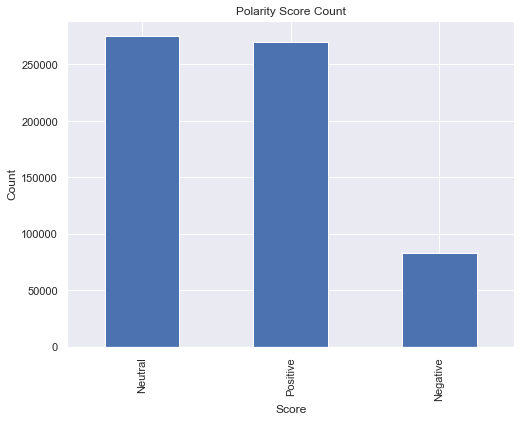

In [48]:
tweets_df['Score'].value_counts().plot(kind='bar')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Polarity Score Count')
plt.show()

<AxesSubplot:xlabel='Score', ylabel='count'>

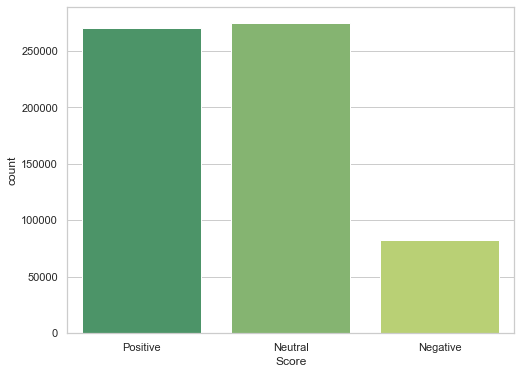

In [49]:
sns.set_style('whitegrid')
sns.countplot(x='Score',data=tweets_df, palette='summer')

In [50]:
tweets_df.head(5)

,date,text,day,week,month,Pfizer,Polarity,Score,length,Score_Encoded
0,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,18,34,8,0,0.4000,Positive,126,1
1,2020-08-18 12:55:00,CoronavirusVaccine CoronaVaccine CovidVaccine ...,18,34,8,0,0.9100,Positive,75,1
2,2020-08-18 12:46:00,Deaths due to COVID-19 in Affected Countries\n...,18,34,8,0,0.1875,Positive,60,1
3,2020-08-18 12:45:00,Stay safe di &amp; da ❤️❤️…,18,34,8,0,0.5000,Positive,33,1
4,2020-08-18 12:45:00,This is what passes for leadership in our co...,18,34,8,0,0.0000,Neutral,85,0


In [51]:
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [52]:
tweets_df.tail(3)

,date,text,day,week,month,Pfizer,Polarity,Score,length,Score_Encoded
627849,2021-11-15 08:30:15,18-44 URBAN Bengaluru CovidVaccine Availabilit...,15,46,11,0,0.2,Positive,113,1
627850,2021-11-15 08:03:03,They promote their Vaccines leaving out the st...,15,46,11,0,0.0,Neutral,72,0
627851,2021-11-15 08:00:15,45+ URBAN Bengaluru CovidVaccine Availability ...,15,46,11,0,0.2,Positive,113,1


In [53]:
print(tweets_df.columns)

Index(['date', 'text', 'day', 'week', 'month', 'Pfizer', 'Polarity', 'Score',
       'length', 'Score_Encoded'],
      dtype='object')


In [54]:
tweets_df.set_index('date', inplace=True)

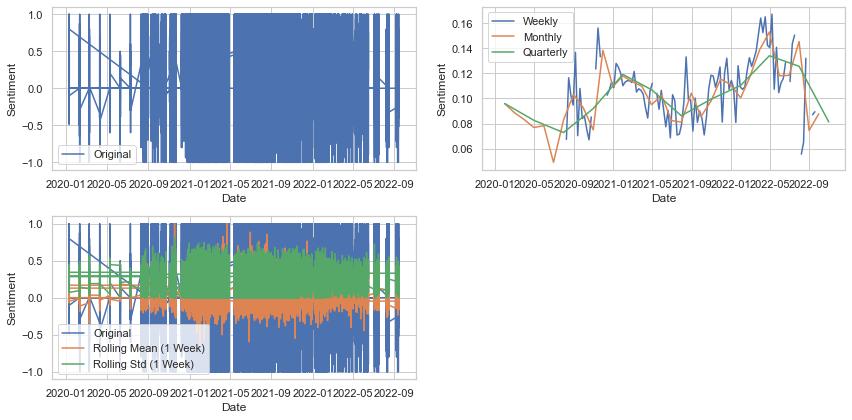

In [55]:
# Resample the data at different intervals
weekly_sentiment = tweets_df['Polarity'].resample('W').mean()
monthly_sentiment = tweets_df['Polarity'].resample('M').mean()
quarterly_sentiment = tweets_df['Polarity'].resample('3M').mean()

# Ploting the original sentiment data, resampled data, and rolling statistics
plt.figure(figsize=(12, 6))

# original sentiment data
plt.subplot(2, 2, 1)
plt.plot(tweets_df['Polarity'], label='Original')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

# resampled data
plt.subplot(2, 2, 2)
plt.plot(weekly_sentiment, label='Weekly')
plt.plot(monthly_sentiment, label='Monthly')
plt.plot(quarterly_sentiment, label='Quarterly')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

# rolling mean and rolling standard deviation
plt.subplot(2, 2, 3)
rolling_mean = tweets_df['Polarity'].rolling(window=7).mean()  # Example: 7day/1 week rolling mean
rolling_std = tweets_df['Polarity'].rolling(window=7).std()  # Example: 7 day/1week rolling standard deviation
plt.plot(tweets_df['Polarity'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (1 Week)')
plt.plot(rolling_std, label='Rolling Std (1 Week)')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

plt.tight_layout() 
plt.show()

In [56]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Reduce the dataset by sampling a subset and taking only 50% of data because of memory error
sampled_df = tweets_df.sample(frac=0.5, random_state=42)  

# Define the desired date range
start_date = '2021-01-01'
end_date = '2021-12-31'

# Filter the sampled DataFrame based on the date range
filtered_df = sampled_df.loc[start_date:end_date]

# Perform the Augmented Dickey-Fuller (ADF) test
result = adfuller(filtered_df['Polarity'])

# Extract the test statistics, p-value, lags used, and number of observations used
test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
num_observations = result[3]

# Print the ADF test results
print("ADF Test Results:")
print("Test Statistics:", test_statistic)
print("p-value:", p_value)
print("Lags Used:", lags_used)
print("Number of Observations Used:", num_observations)

ADF Test Results:
Test Statistics: -517.6627444613317
p-value: 0.0
Lags Used: 0
Number of Observations Used: 268296


In [57]:
# Group by week
tweets_weekly = tweets_df.groupby(pd.Grouper(freq='W')).sum()

# Group by month
tweets_monthly = tweets_df.groupby(pd.Grouper(freq='M')).sum()

# Group by quarter
tweets_quarterly = tweets_df.groupby(pd.Grouper(freq='Q')).sum()


In [58]:
import statsmodels.api as sm
result_weekly = sm.tsa.seasonal_decompose(tweets_weekly['Polarity'], model='additive')
result_monthly = sm.tsa.seasonal_decompose(tweets_monthly['Polarity'], model='additive')
result_quarterly = sm.tsa.seasonal_decompose(tweets_quarterly['Polarity'], model = 'additive')

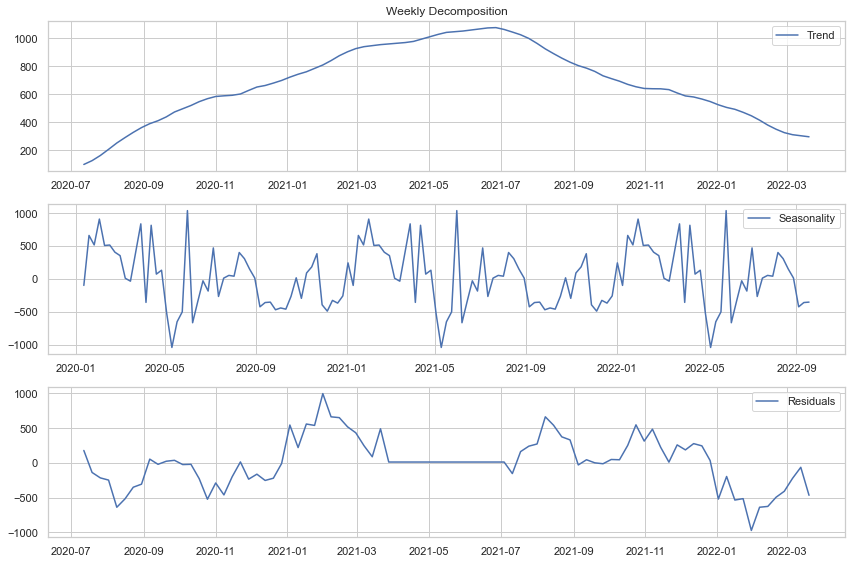

In [59]:
# Access the decomposition components
trend_weekly = result_weekly.trend
seasonal_weekly = result_weekly.seasonal
residual_weekly = result_weekly.resid

# Visualize the components
plt.figure(figsize=(12, 8))

# Plotting the weekly decomposition
plt.subplot(3, 1, 1)
plt.plot(trend_weekly, label='Trend')
plt.legend()
plt.title('Weekly Decomposition')

plt.subplot(3, 1, 2)
plt.plot(seasonal_weekly, label='Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(residual_weekly, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


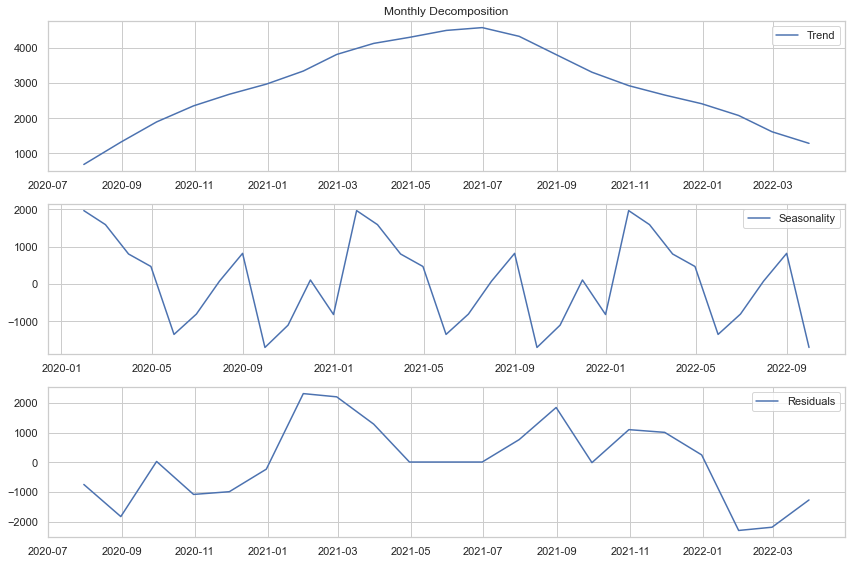

In [60]:
# Access the decomposition components

trend_monthly = result_monthly.trend
seasonal_monthly = result_monthly.seasonal
residual_monthly = result_monthly.resid

# Visualize the components
plt.figure(figsize=(12, 8))

# Plotting the Monthly decomposition
plt.subplot(3, 1, 1)
plt.plot(trend_monthly, label='Trend')
plt.legend()
plt.title('Monthly Decomposition')

plt.subplot(3, 1, 2)
plt.plot(seasonal_monthly, label='Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(residual_monthly, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

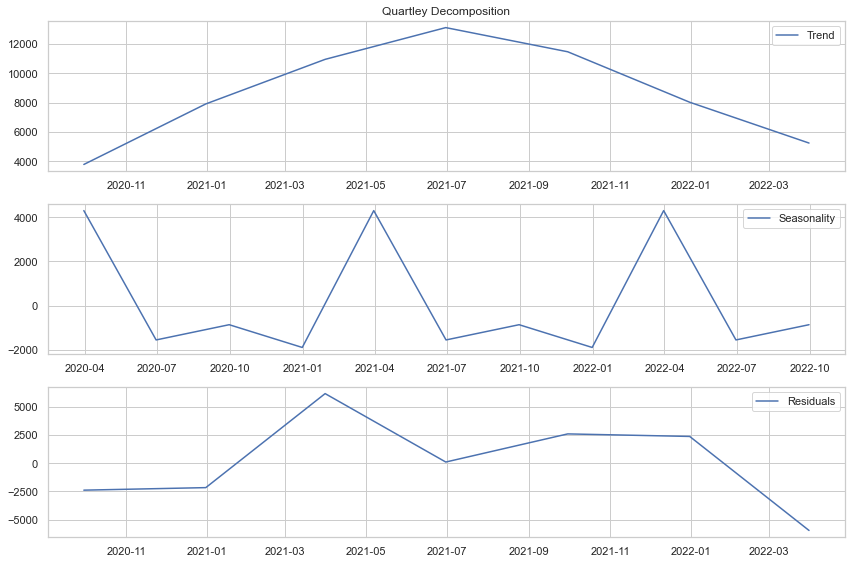

In [61]:
import matplotlib.pyplot as plt

# Access the decomposition components
trend_quarterly = result_quarterly.trend
seasonal_quarterly = result_quarterly.seasonal
residual_quarterly = result_quarterly.resid

# Visualize the components
plt.figure(figsize=(12, 8))

# Plotting the quarterly decomposition
plt.subplot(3, 1, 1)
plt.plot(trend_quarterly, label='Trend')
plt.legend()
plt.title('Quartley Decomposition')

plt.subplot(3, 1, 2)
plt.plot(seasonal_quarterly, label='Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(residual_quarterly, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

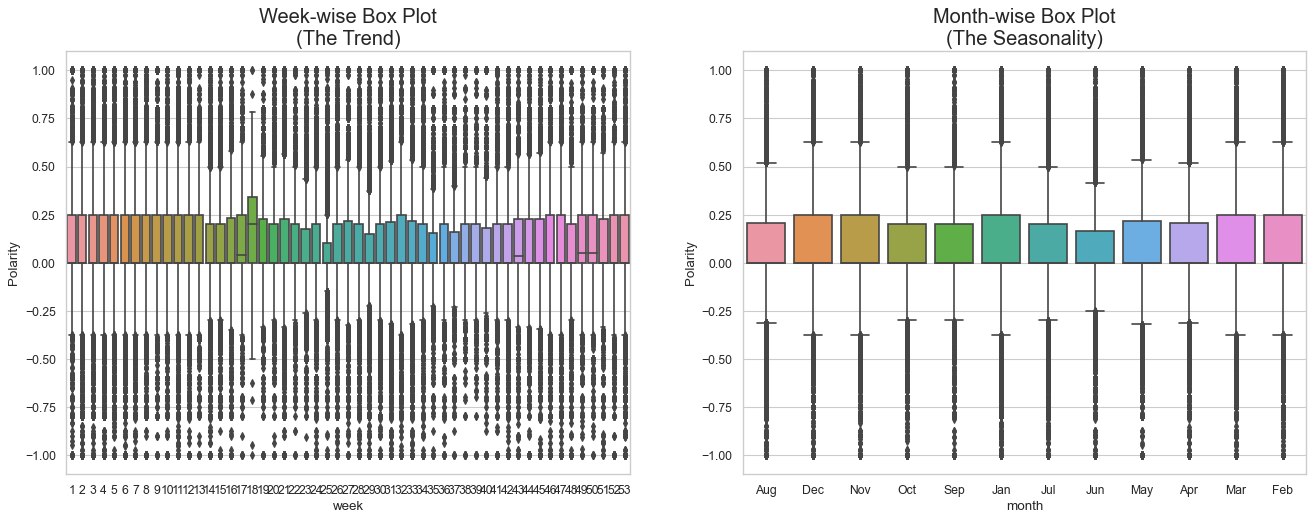

In [62]:
# Create 'week' and 'month' columns
tweets_df['week'] = tweets_df.index.week
tweets_df['month'] = tweets_df.index.strftime('%b')

# Get unique weeks and months
weeks = tweets_df['week'].unique()
months = tweets_df['month'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x='week', y='Polarity', data=tweets_df, ax=axes[0])
sns.boxplot(x='month', y='Polarity', data=tweets_df, ax=axes[1])

# Set Title
axes[0].set_title('Week-wise Box Plot\n(The Trend)', fontsize=18)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()


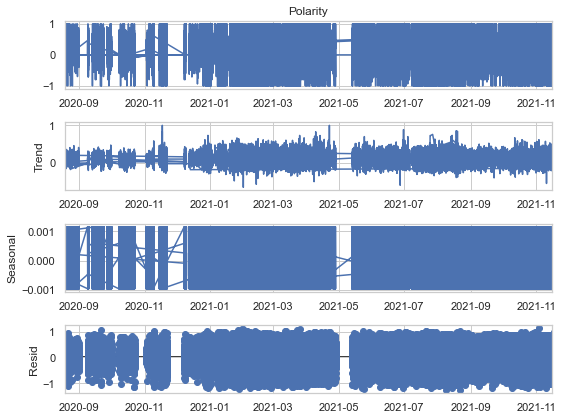

In [63]:
result = seasonal_decompose(tweets_df['Polarity'], model='additive', period=7)
result.plot()
plt.show()

In [64]:
def plot_bar_count():
    # Bar plot and count plot code here
    bar_plot = tweets_df['Score'].value_counts().plot(kind='bar')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title('Polarity Score Count')
    plt.show()
    count_plot = sns.set_style('whitegrid')
    sns.countplot(x='Score',data=tweets_df, palette='summer')
    return pn.panel(bar_plot), pn.panel(count_plot)

In [65]:
def plot_densitygraph():
    # Reset the index of the DataFrame
    tweets_df_reset = tweets_df.reset_index(drop=True)
    
    # Plot the density graph
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=tweets_df_reset, x='length', fill=True, hue='Score', alpha=0.5)
    
    # Set the plot title and axis labels
    plt.title('Tweet Length Distribution by Sentiment')
    plt.xlabel('Tweet Length')
    plt.ylabel('Density')
    
    # Display the plot
    plt.show()

In [66]:
def plot_sentimentdensitygraph():
    # Create a copy of the DataFrame
    tweets_df_copy = tweets_df.copy()
    
    # Reset the index
    tweets_df_copy = tweets_df_copy.reset_index(drop=True)
    
    # Set the figure size
    sns.set(rc={'figure.figsize': (8, 6)})
    
    # Create the density plot
    sns.kdeplot(data=tweets_df_copy, x='Score_Encoded', fill=True, palette=['red', 'blue', 'green'])
    
    # Set the plot title and axis labels
    plt.title('Sentiment Density Plot')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    
    # Show the plot
    plt.show()


In [67]:
def plot_resampled_data():
    # Resampled data plot code here
    resampled_plot =weekly_sentiment = tweets_df['Polarity'].resample('W').mean()
    monthly_sentiment = tweets_df['Polarity'].resample('M').mean()
    quarterly_sentiment = tweets_df['Polarity'].resample('3M').mean()

    # Plot the original sentiment data, resampled data, and rolling statistics
    plt.figure(figsize=(12, 6))

    # Plot the original sentiment data
    plt.subplot(2, 2, 1)
    plt.plot(tweets_df['Polarity'], label='Original')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.legend()

    # Plot the resampled data
    plt.subplot(2, 2, 2)
    plt.plot(weekly_sentiment, label='Weekly')
    plt.plot(monthly_sentiment, label='Monthly')
    plt.plot(quarterly_sentiment, label='Quarterly')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.legend()

    # Plot the rolling mean and rolling standard deviation
    plt.subplot(2, 2, 3)
    rolling_mean = tweets_df['Polarity'].rolling(window=7).mean()  # Example: 7day/1 week rolling mean
    rolling_std = tweets_df['Polarity'].rolling(window=7).std()  # Example: 7 day/1week rolling standard deviation
    plt.plot(tweets_df['Polarity'], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean (1 Week)')
    plt.plot(rolling_std, label='Rolling Std (1 Week)')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.legend()

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()
    return pn.panel(resampled_plot)

In [68]:
def plot_weeklydecomposition():
    # Decomposition plot code here
    weeklydecomposition_plot =trend_weekly = result_weekly.trend
    seasonal_weekly = result_weekly.seasonal
    residual_weekly = result_weekly.resid

    # Visualize the components
    plt.figure(figsize=(12, 8))

    # Plotting the weekly decomposition
    plt.subplot(3, 1, 1)
    plt.plot(trend_weekly, label='Trend')
    plt.legend()
    plt.title('Weekly Decomposition')

    plt.subplot(3, 1, 2)
    plt.plot(seasonal_weekly, label='Seasonality')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(residual_weekly, label='Residuals')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return pn.panel(weeklydecomposition_plot)

In [69]:
def plot_monthlydecomposition():
    # Decomposition plot code here
    monthlydecomposition_plot =trend_monthly = result_monthly.trend
    seasonal_monthly = result_monthly.seasonal
    residual_monthly = result_monthly.resid

    # Visualize the components
    plt.figure(figsize=(12, 8))

    # Plotting the weekly decomposition
    plt.subplot(3, 1, 1)
    plt.plot(trend_monthly, label='Trend')
    plt.legend()
    plt.title('Monthly Decomposition')

    plt.subplot(3, 1, 2)
    plt.plot(seasonal_monthly, label='Seasonality')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(residual_monthly, label='Residuals')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return pn.panel(monthlydecomposition_plot)

In [70]:
def plot_quarterlydecomposition():
    # Decomposition plot code here
    quarterlydecomposition_plot =trend_quarterly = result_quarterly.trend
    seasonal_quarterly = result_quarterly.seasonal
    residual_quarterly = result_quarterly.resid

    # Visualize the components
    plt.figure(figsize=(12, 8))

    # Plotting the Quarterly decomposition
    plt.subplot(3, 1, 1)
    plt.plot(trend_quarterly, label='Trend')
    plt.legend()
    plt.title('quarterly Decomposition')

    plt.subplot(3, 1, 2)
    plt.plot(seasonal_quarterly, label='Seasonality')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(residual_quarterly, label='Residuals')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return pn.panel(quarterlydecomposition_plot)

In [71]:
def plot_box_plots():

    box_plots = tweets_df['week'] = tweets_df.index.week
    tweets_df['month'] = tweets_df.index.strftime('%b')

    # Get unique weeks and months
    weeks = tweets_df['week'].unique()
    months = tweets_df['month'].unique()

    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
    sns.boxplot(x='week', y='Polarity', data=tweets_df, ax=axes[0])
    sns.boxplot(x='month', y='Polarity', data=tweets_df, ax=axes[1])

    # Set Title
    axes[0].set_title('Week-wise Box Plot\n(The Trend)', fontsize=18)
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

    plt.show()
    return pn.panel(box_plots)

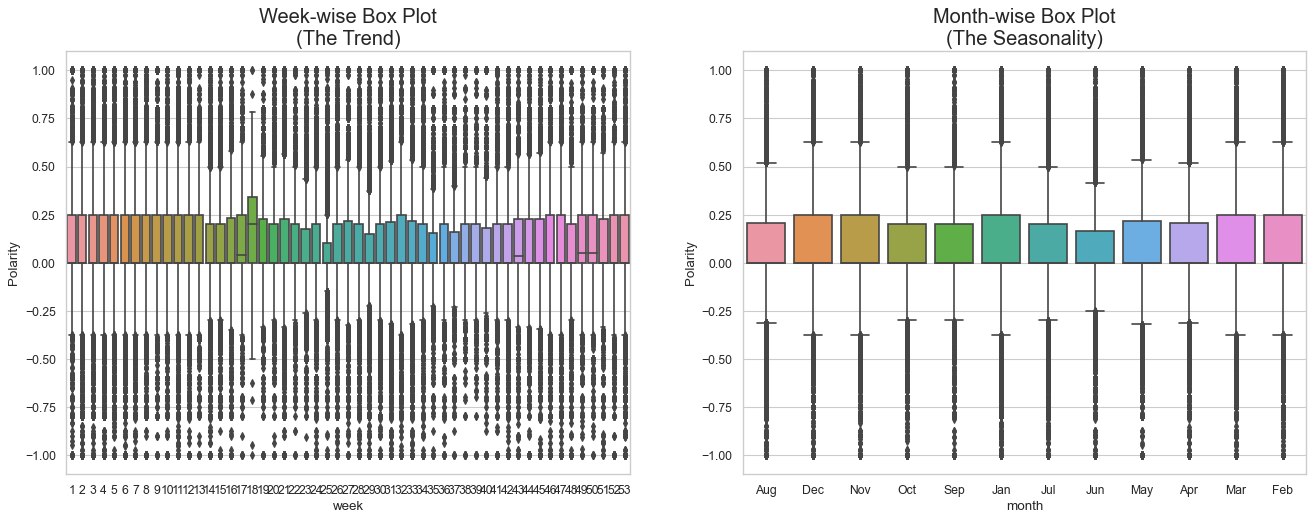

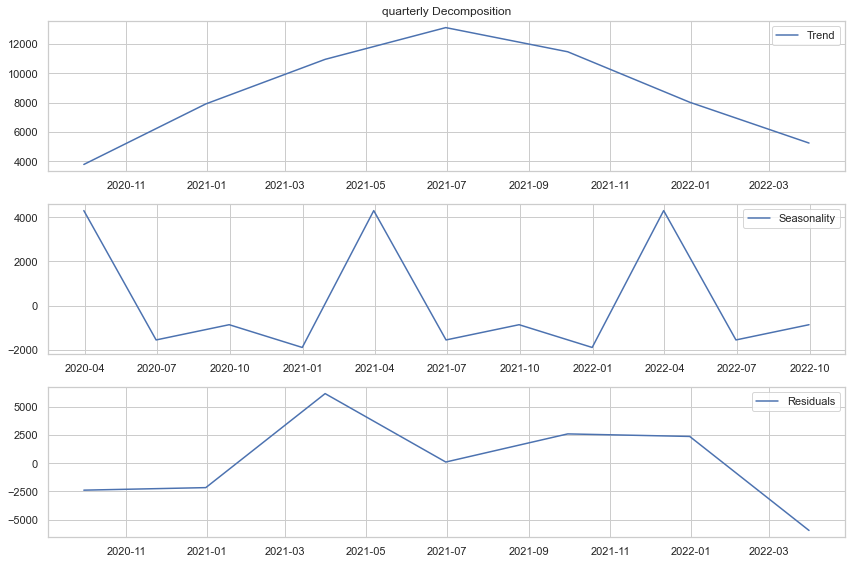

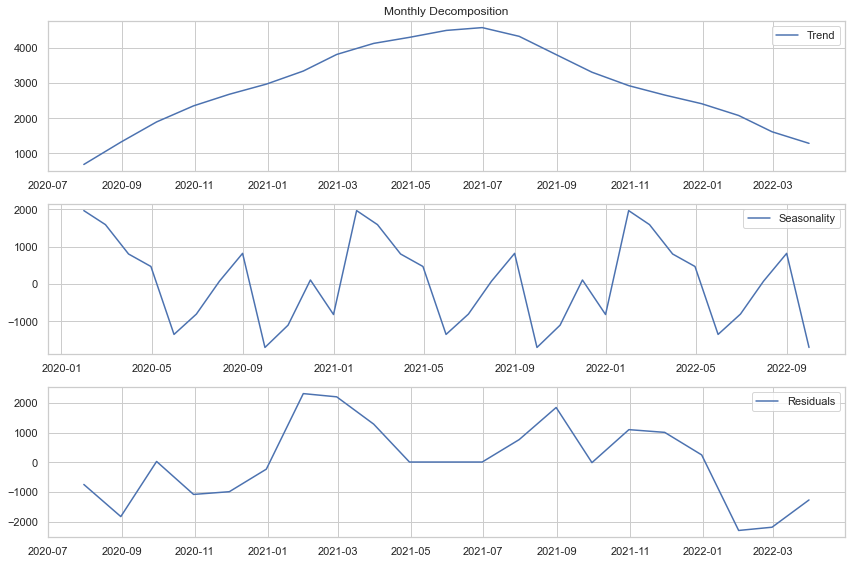

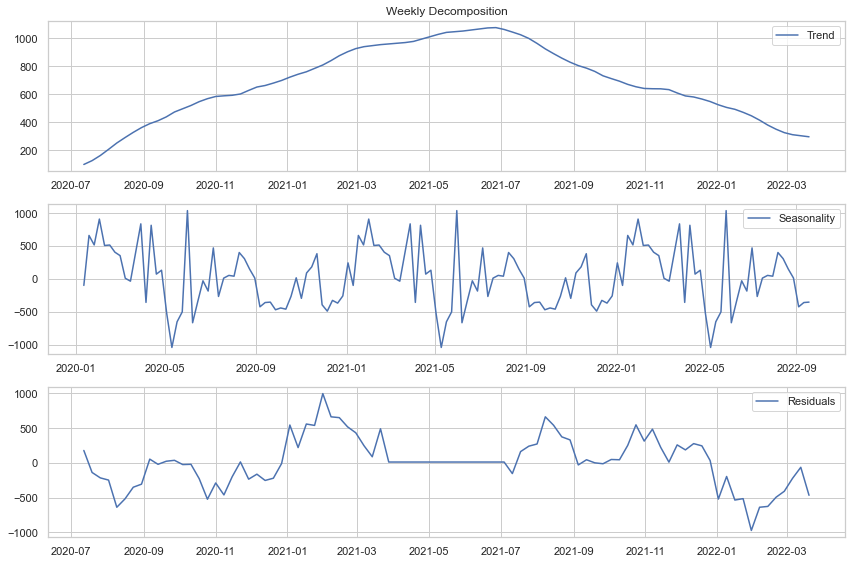

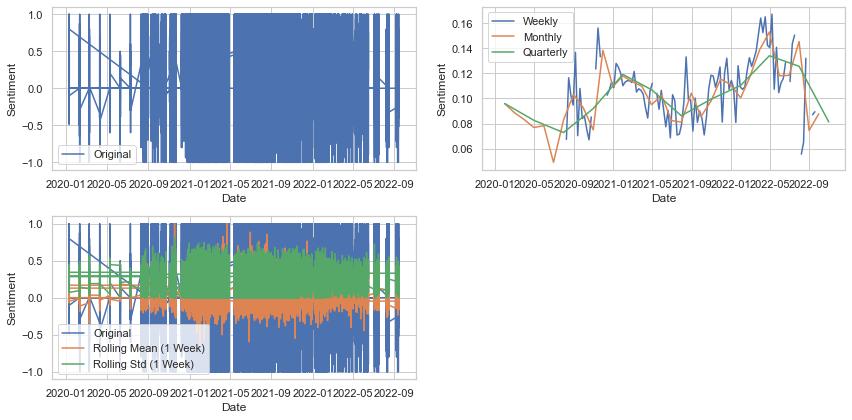

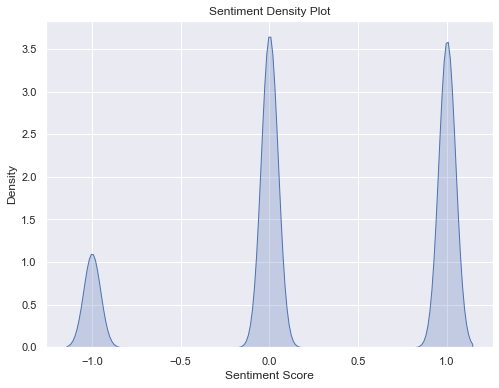

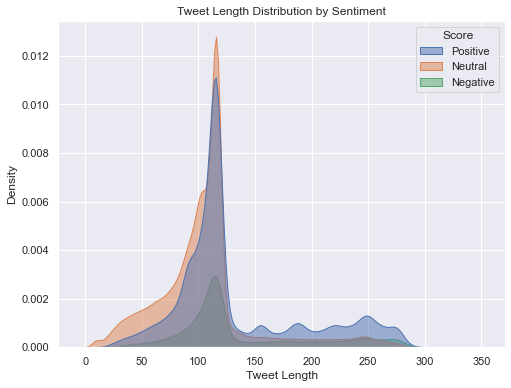

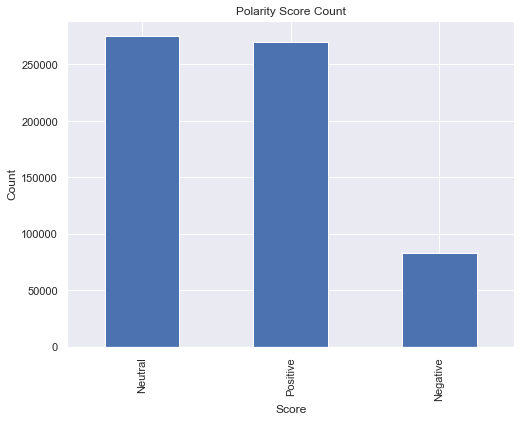

Launching server at http://localhost:60726


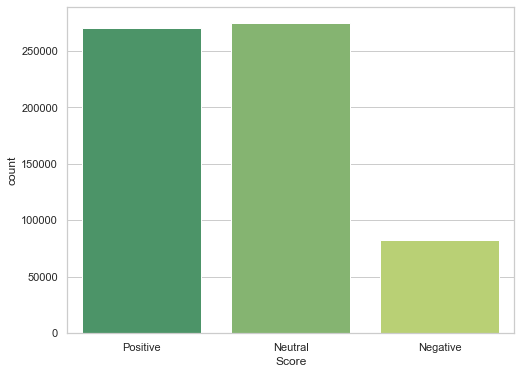

In [72]:
import panel as pn
import matplotlib.pyplot as plt
import seaborn as sns

# Define the layout of the dashboard
dashboard = pn.Tabs(
    ('Box Plots', plot_box_plots()),
    ('Quarterly Decomposition', plot_quarterlydecomposition()),
    ('Monthly Decomposition', plot_monthlydecomposition()),
    ('Weekly Decomposition', plot_weeklydecomposition()),
    ('Resampled Data', plot_resampled_data()),
    ('Sentiment Density Graph', plot_sentimentdensitygraph()),
    ('Density Graph', plot_densitygraph()),
    ('Bar Plot and Count Plot', plot_bar_count())
)

# Start the Panel app
dashboard.show()


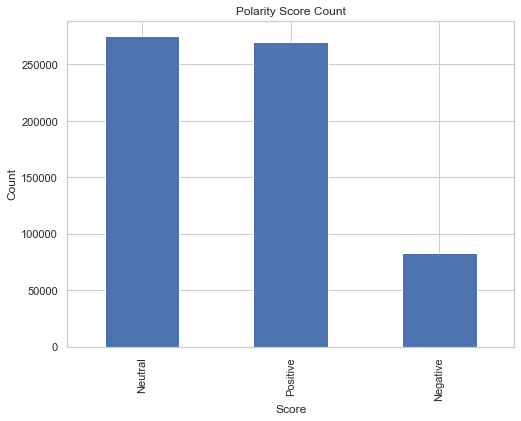

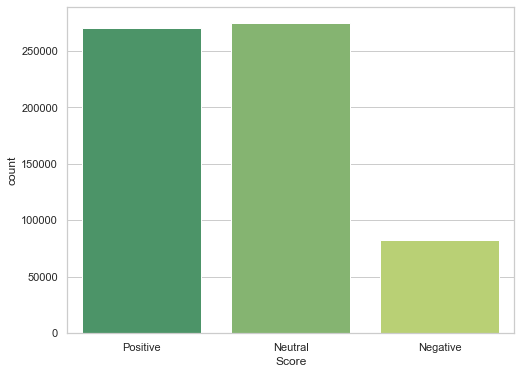

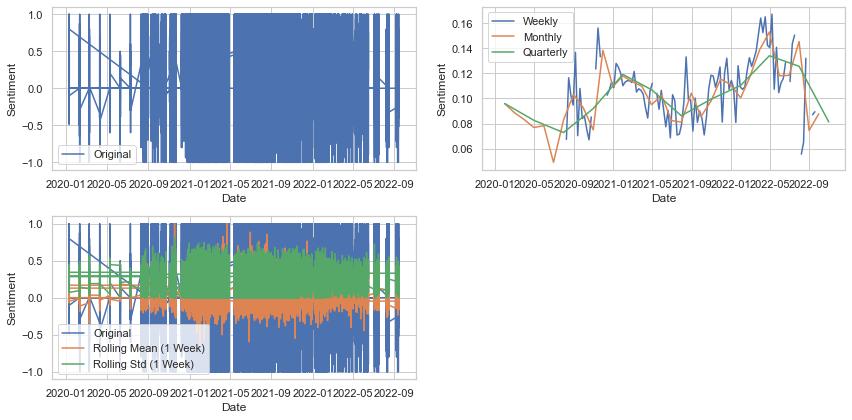

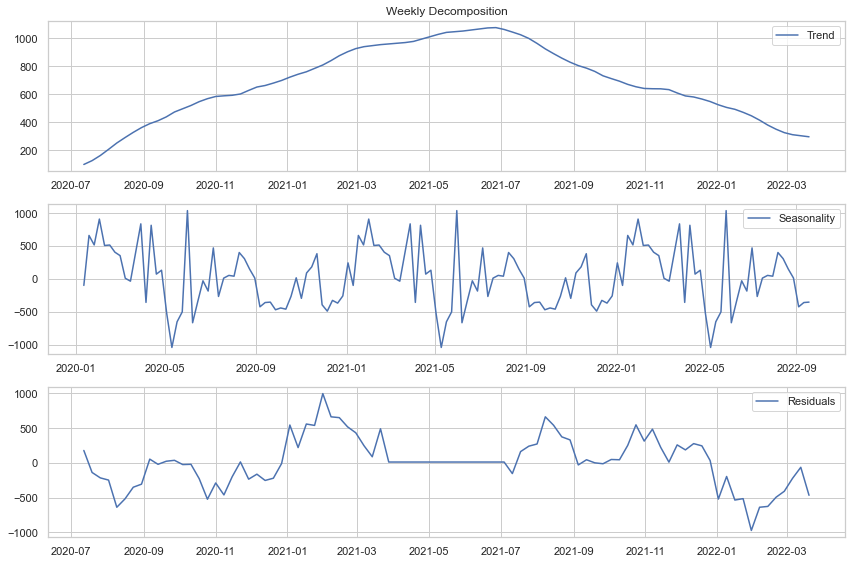

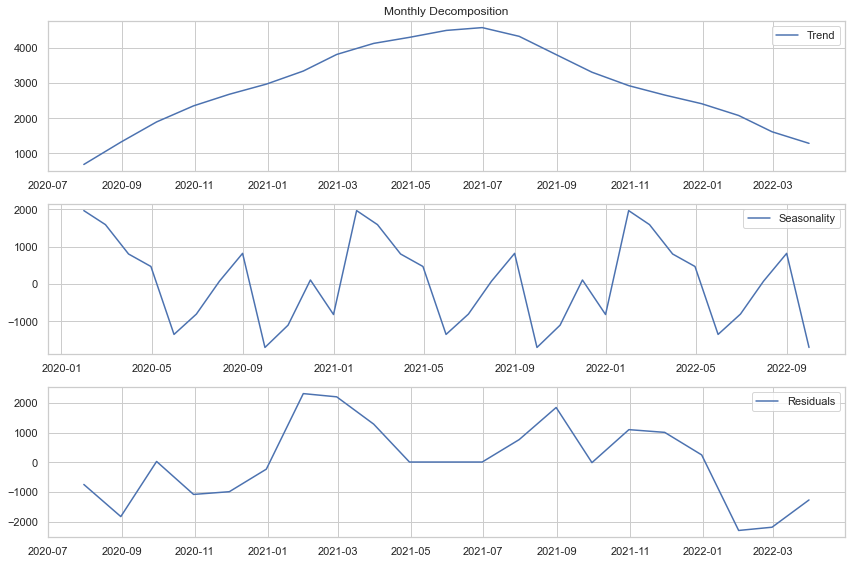

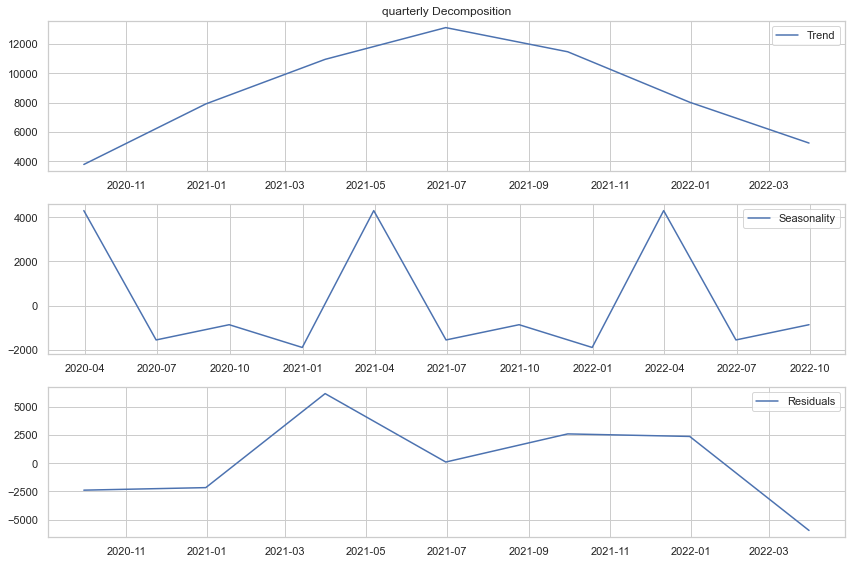

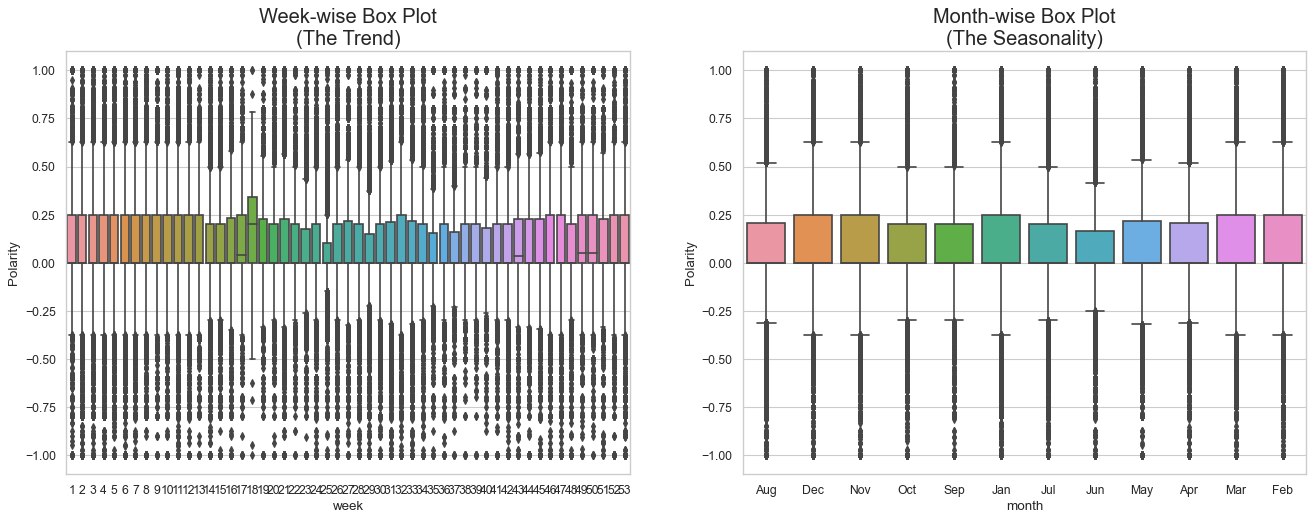

Launching server at http://localhost:60736


In [73]:
import panel as pn

# Create new DataFrame objects with unique indices
tweets_df_unique_index = tweets_df.reset_index(drop=True).copy()

# Generate the visualization panels
bar_panel, count_panel = plot_bar_count()
resampled_panel = plot_resampled_data()
weeklydecomposition_panel = plot_weeklydecomposition()
monthlydecomposition_panel = plot_monthlydecomposition()
quarterlydecomposition_panel = plot_quarterlydecomposition()
box_panel = plot_box_plots()

# Create the layout of the dashboard
row1 = pn.Row(bar_panel, count_panel)
row2 = pn.Row(resampled_panel)
row3 = pn.Row(weeklydecomposition_panel, monthlydecomposition_panel, quarterlydecomposition_panel)
layout = pn.Column(row1, row2, row3, box_panel)
dashboard = pn.Tabs(('Plots', layout))

# Start the Panel app
dashboard.show()
